c:\Users\iltergo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\iltergo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\iltergo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\iltergo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, 

Cross-Validation Results:
Least Squares: RMSE=38.7003 ± 0.3936, MAE=27.6853 ± 0.1979, R2=0.9653 ± 0.0005
Ridge Regression: RMSE=38.7003 ± 0.3936, MAE=27.6852 ± 0.1978, R2=0.9653 ± 0.0005
Support Vector Regressor: RMSE=14.1288 ± 0.3564, MAE=11.1880 ± 0.1384, R2=0.9954 ± 0.0002
K-Nearest Neighbors: RMSE=14.2783 ± 0.4045, MAE=4.4826 ± 0.1526, R2=0.9953 ± 0.0003


c:\Users\iltergo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\iltergo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


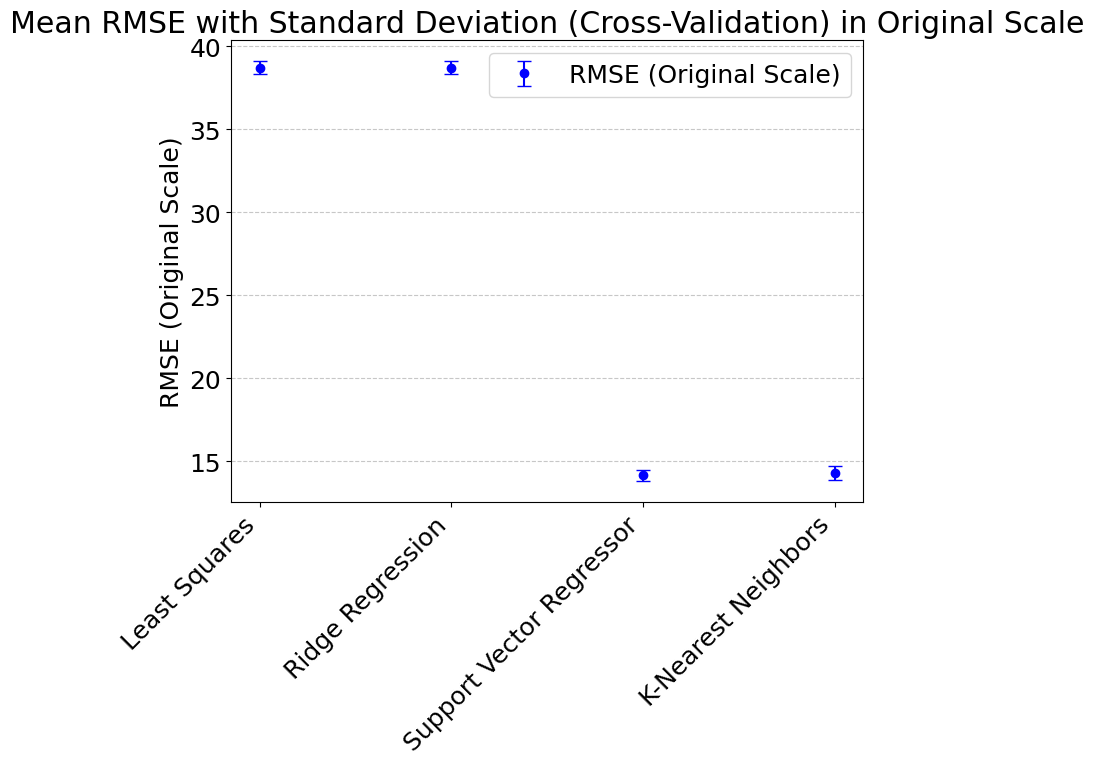

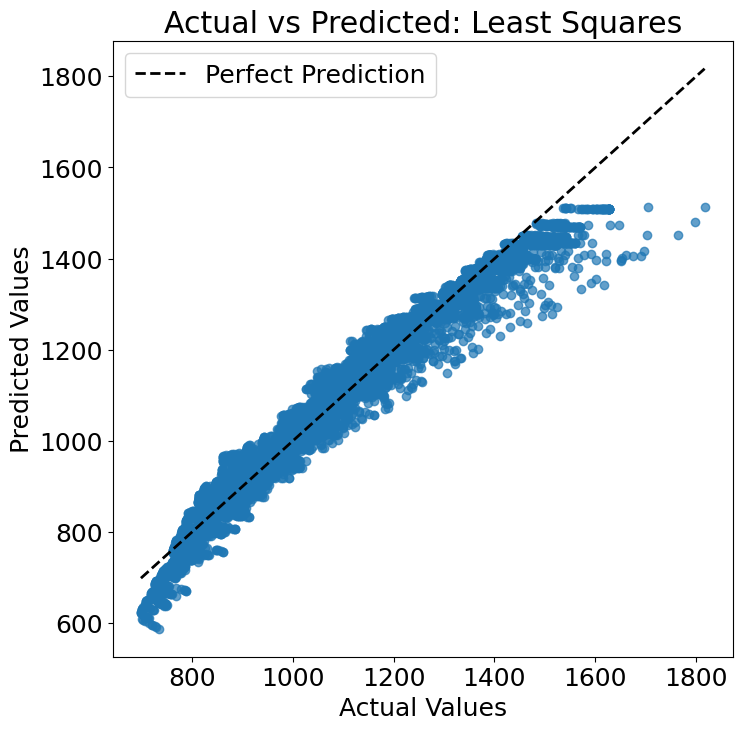

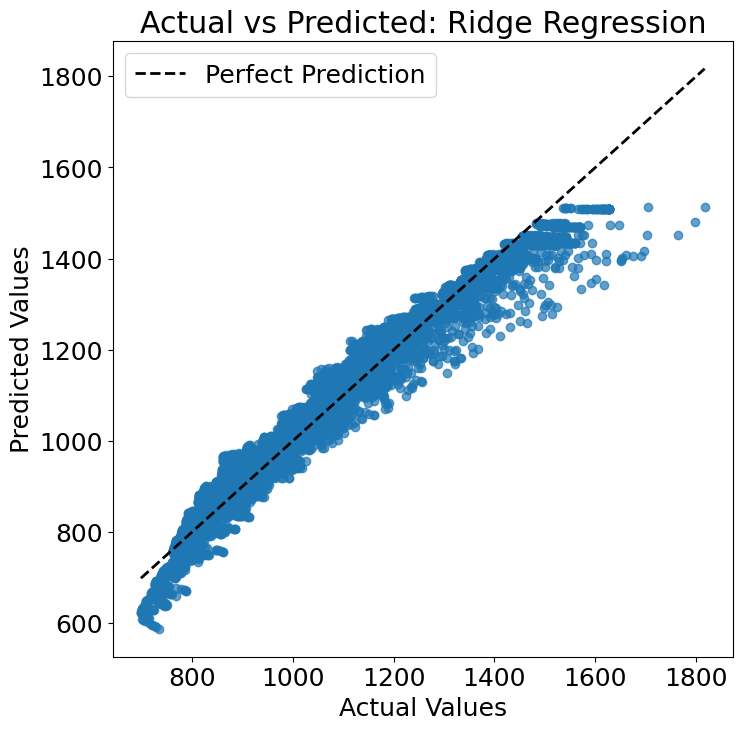

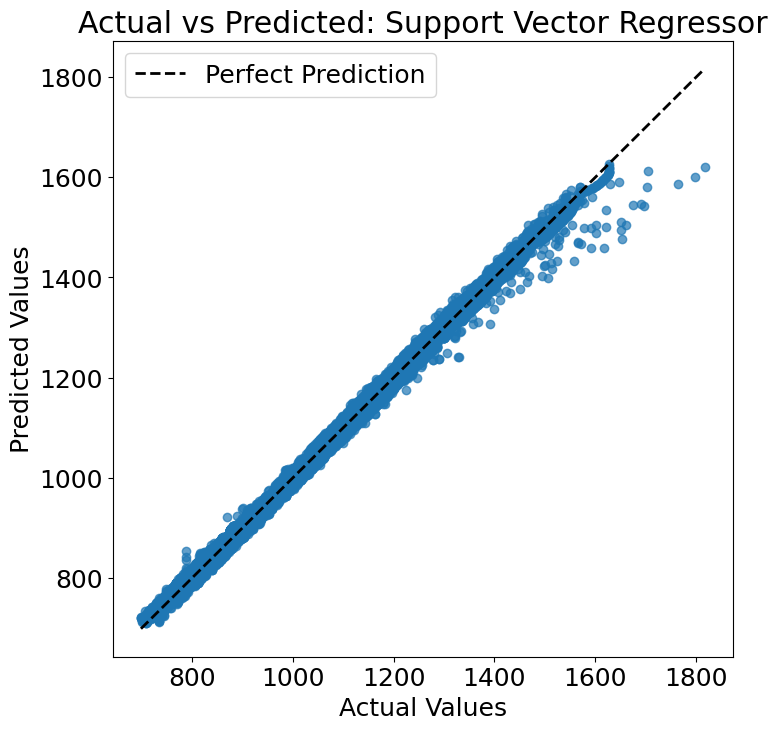

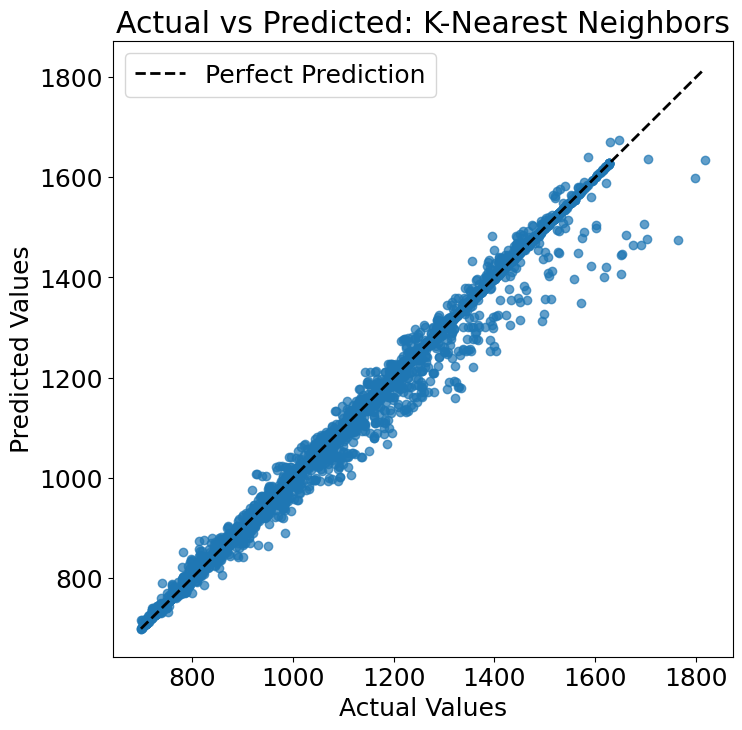

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


plt.rcParams.update({'font.size': 18})


file_path = "simulation_results_with_pressure_without_early_values.csv"  # Replace with your file path
df = pd.read_csv(file_path)


filtered_df = df[~df['time'].isin([0, 1])]
df = filtered_df


X = df.drop(columns=["volAverage(T)", "volAverage(Bu)", "rodPressure"])
y = df["volAverage(T)"]


num_bins = 10
y_bins = pd.qcut(y, q=num_bins, duplicates='drop', labels=False)

# Train-validation-test split with stratification based on binned target values
X_train, X_temp, y_train, y_temp, y_bins_train, y_bins_temp = train_test_split(
    X, y, y_bins, test_size=0.2, random_state=42, stratify=y_bins
)

X_val, X_test, y_val, y_test, y_bins_val, y_bins_test = train_test_split(
    X_temp, y_temp, y_bins_temp, test_size=0.5, random_state=42, stratify=y_bins_temp
)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


target_scaler = StandardScaler()
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val_scaled = target_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Subsample the training set for computationally expensive models
subsample_size = 10000
train_subsample_indices = np.random.choice(len(X_train_scaled), subsample_size, replace=False)
X_train_subsampled = X_train_scaled[train_subsample_indices]
y_train_subsampled = y_train_scaled[train_subsample_indices]

# Evaluate model with hyperparameters using cross-validation
def evaluate_model_with_hyperparameters(model, param_grid, X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    rmse_scores_original = []
    mae_scores_original = []
    r2_scores_original = []

    best_model = None
    best_rmse_scaled = float("inf")  # Best model selection is based on scaled RMSE
    best_params = None

    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        
        grid_search = GridSearchCV(model, param_grid, scoring='neg_root_mean_squared_error', cv=3, n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_fold_model = grid_search.best_estimator_

        # Predictions in scaled space
        y_val_pred_scaled = best_fold_model.predict(X_val)
        y_val_pred_original = target_scaler.inverse_transform(y_val_pred_scaled.reshape(-1, 1)).flatten()
        y_val_original = target_scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()

        # Calculate metrics in the original scale
        rmse_original = mean_squared_error(y_val_original, y_val_pred_original, squared=False)
        mae_original = mean_absolute_error(y_val_original, y_val_pred_original)
        r2_original = r2_score(y_val_original, y_val_pred_original)

        rmse_scores_original.append(rmse_original)
        mae_scores_original.append(mae_original)
        r2_scores_original.append(r2_original)

        # Choose the best model based on scaled RMSE
        rmse_scaled = mean_squared_error(y_val, y_val_pred_scaled, squared=False)
        if rmse_scaled < best_rmse_scaled:
            best_rmse_scaled = rmse_scaled
            best_model = best_fold_model
            best_params = grid_search.best_params_

    return {
        "best_model": best_model,
        "best_params": best_params,
        "RMSE": np.mean(rmse_scores_original),
        "RMSE_std": np.std(rmse_scores_original),
        "MAE": np.mean(mae_scores_original),
        "MAE_std": np.std(mae_scores_original),
        "R2": np.mean(r2_scores_original),
        "R2_std": np.std(r2_scores_original),
    }


models_and_params = {
    "Least Squares": {
        "model": LinearRegression(),
        "param_grid": {}
    },
    "Ridge Regression": {
        "model": Ridge(),
        "param_grid": {"alpha": [0.1, 1.0, 10.0, 100.0]}
    },
    "Support Vector Regressor": {
        "model": SVR(),
        "param_grid": {"C": [0.1, 1.0, 10.0], "kernel": ["linear", "rbf"]}
    },
    "K-Nearest Neighbors": {
        "model": KNeighborsRegressor(),
        "param_grid": {"n_neighbors": [3, 5, 10, 20], "weights": ["uniform", "distance"]}
    }
}


results = {}
for name, config in models_and_params.items():
    if name in ["Support Vector Regressor", "K-Nearest Neighbors"]:
        results[name] = evaluate_model_with_hyperparameters(
            config["model"], config["param_grid"], X_train_subsampled, y_train_subsampled
        )
    else:
        results[name] = evaluate_model_with_hyperparameters(
            config["model"], config["param_grid"], X_train_scaled, y_train_scaled
        )


print("Cross-Validation Results:")
for name, metrics in results.items():
    print(f"{name}: RMSE={metrics['RMSE']:.4f} ± {metrics['RMSE_std']:.4f}, "
          f"MAE={metrics['MAE']:.4f} ± {metrics['MAE_std']:.4f}, "
          f"R2={metrics['R2']:.4f} ± {metrics['R2_std']:.4f}")


# Plot RMSE and standard deviation in the original scale
plt.figure(figsize=(8, 8))

x = np.arange(len(results))
mean_rmse_original = [metrics["RMSE"] for metrics in results.values()]
std_rmse_original = [metrics["RMSE_std"] for metrics in results.values()]

plt.errorbar(
    x, mean_rmse_original, yerr=std_rmse_original,
    fmt='o', capsize=5, color='blue', label='RMSE (Original Scale)'
)
plt.xticks(x, results.keys(), rotation=45, ha='right')
plt.ylabel("RMSE (Original Scale)")
plt.title("Mean RMSE with Standard Deviation (Cross-Validation) in Original Scale")
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

# Plot actual vs predicted for test set
for name, result in results.items():
    best_model = result["best_model"]
    y_test_pred_scaled = best_model.predict(X_test_scaled)
    y_test_pred = target_scaler.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()

    plt.figure(figsize=(8, 8))
    plt.scatter(y_test, y_test_pred, alpha=0.7)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=2, label="Perfect Prediction")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"Actual vs Predicted: {name}")
    plt.legend()
    plt.show()


In [2]:
print("\nBest Hyperparameters for Each Model:")
for name, result in results.items():
    print(f"{name}: Best Hyperparameters = {result['best_params']}")



Best Hyperparameters for Each Model:
Least Squares: Best Hyperparameters = {}
Ridge Regression: Best Hyperparameters = {'alpha': 0.1}
Support Vector Regressor: Best Hyperparameters = {'C': 10.0, 'kernel': 'rbf'}
K-Nearest Neighbors: Best Hyperparameters = {'n_neighbors': 3, 'weights': 'distance'}


In [3]:
print("Test Results:")
for name, result in results.items():
    best_model = result["best_model"]
    y_test_pred_scaled = best_model.predict(X_test_scaled)
    y_test_pred = target_scaler.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()

    # Calculate metrics in the original scale
    rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)

    print(f"{name}: RMSE={rmse_test:.4f}, MAE={mae_test:.4f}, R2={r2_test:.4f}")

Test Results:
Least Squares: RMSE=38.6048, MAE=27.5958, R2=0.9655
Ridge Regression: RMSE=38.6048, MAE=27.5958, R2=0.9655


c:\Users\iltergo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\iltergo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Support Vector Regressor: RMSE=14.7183, MAE=11.2504, R2=0.9950
K-Nearest Neighbors: RMSE=15.5583, MAE=4.7237, R2=0.9944


c:\Users\iltergo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\iltergo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
